In [1]:
import numpy as np

# Load training data
Xtrain = np.loadtxt('Xtrain.csv')

# Load training labels
Ytrain = np.loadtxt('Ytrain.csv')

# Load test data
Xtest = np.loadtxt('Xtest.csv')

In [4]:
import matplotlib.pyplot as plt

## Question No. 5: Optimal Pipeline

*Develop an optimal pipeline for classification based on your analysis (Q1-Q4). You are free to use any tools or approaches at your disposal. However, no external data sources may be used. Describe your pipeline and report your outputs over the test data set. (You are required to submit your prediction file together with the assignment in a zip folder). Your prediction file should be a single column file containing the prediction score of the corresponding example in Xtest (be sure to have the same order as the order of the test examples in Xtest!). Your prediction file should be named by your student ID, e.g., u100011.csv.*

Although preprocessing data with a scaler has been shown to improve the performance of many classifiers, especially Kernelized SVM, unfortunately, due to certain characteristics of the test set, we may have to give up using the scaler.

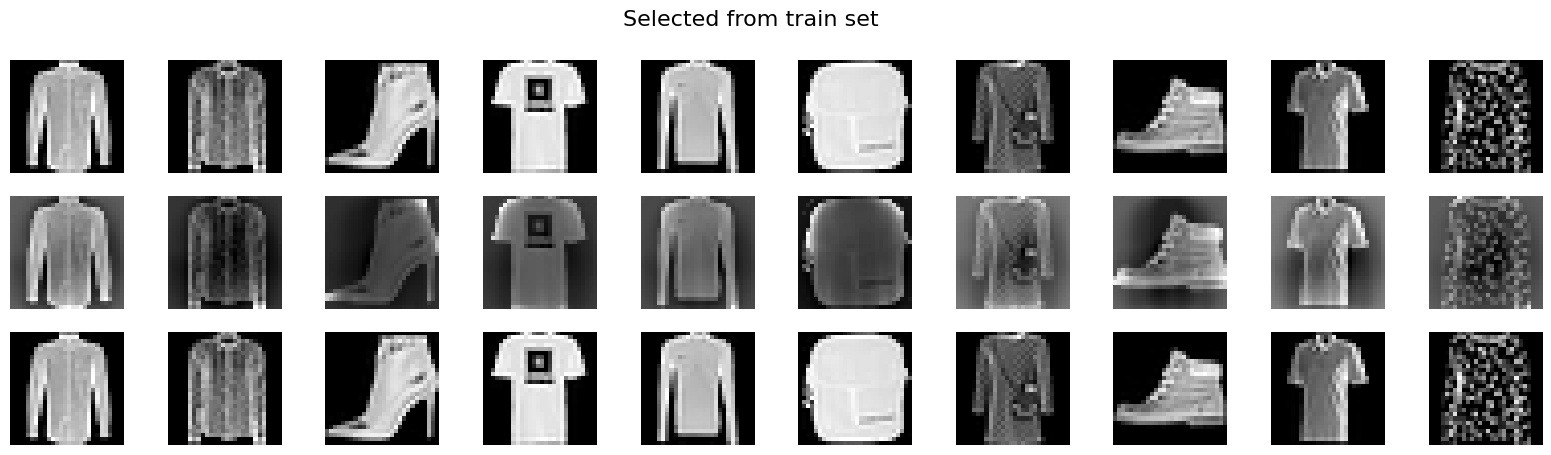

In [49]:
# Create a figure for plotting
fig, axes = plt.subplots(3, 10, figsize=(20, 5))

# Select 10 random objects from each class
random_indices_train = np.random.choice(np.arange(len(Xtrain)), size=10, replace=False)
random_objects_train = Xtrain[random_indices_train]
random_objects_train_standard = Xtrain_standard[random_indices_train]
random_objects_train_minmax = Xtrain_minmax[random_indices_train]

# Reshape and display the flattened 28x28 arrays
for i in range(10):
    axes[0, i].matshow(random_objects_train[i].reshape(28, 28), cmap='gray')
    axes[0, i].axis('off')
    axes[1, i].matshow(random_objects_train_standard[i].reshape(28, 28), cmap='gray')
    axes[1, i].axis('off')
    axes[2, i].matshow(random_objects_train_minmax[i].reshape(28, 28), cmap='gray')
    axes[2, i].axis('off')

# Add a title to the entire figure
plt.suptitle('Selected from train set', fontsize=16)

plt.show()

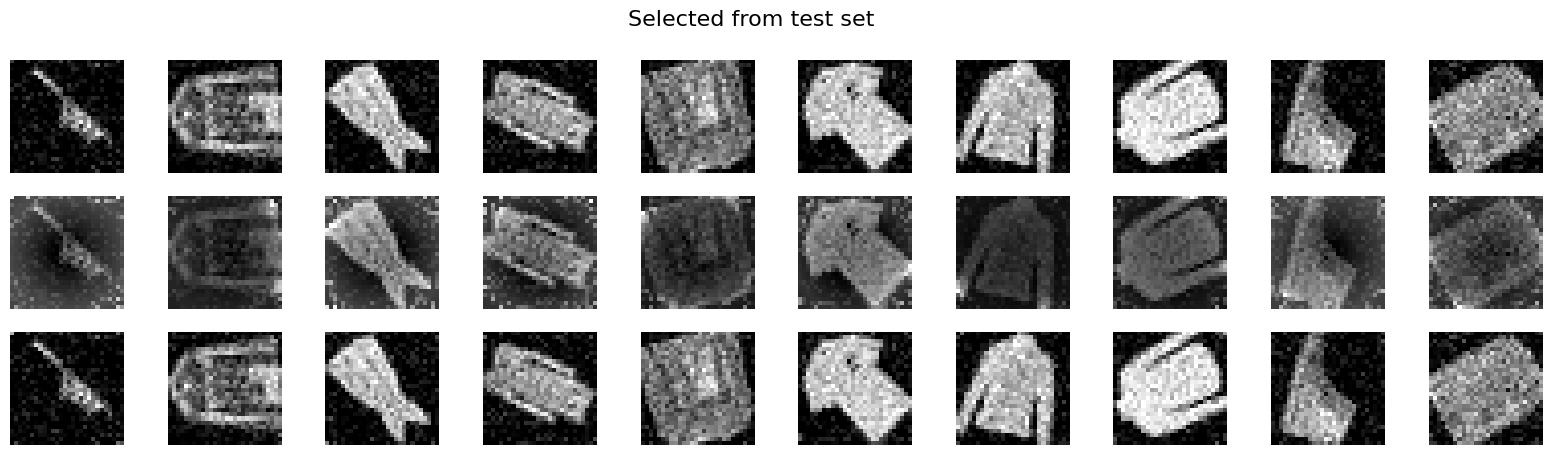

In [50]:
# Create a figure for plotting
fig, axes = plt.subplots(3, 10, figsize=(20, 5))

# Select 10 random objects from each class
random_indices_test = np.random.choice(np.arange(len(Xtest)), size=10, replace=False)
random_objects_test = Xtest[random_indices_test]
random_objects_test_standard = Xtest_standard[random_indices_test]
random_objects_test_minmax = Xtest_minmax[random_indices_test]

# Reshape and display the flattened 28x28 arrays
for i in range(10):
    axes[0, i].matshow(random_objects_test[i].reshape(28, 28), cmap='gray')
    axes[0, i].axis('off')
    axes[1, i].matshow(random_objects_test_standard[i].reshape(28, 28), cmap='gray')
    axes[1, i].axis('off')
    axes[2, i].matshow(random_objects_test_minmax[i].reshape(28, 28), cmap='gray')
    axes[2, i].axis('off')

# Add a title to the entire figure
plt.suptitle('Selected from test set', fontsize=16)

plt.show()

Note that the scaled training data still allows recognition of the content in the images, while the test data, processed with the same scaling parameters, loses a lot of information and becomes unrecognizable. This is likely due to inconsistent data formats, such as different angles of inclination in the images. Although we currently do not know how to align the test images' angles with those of the training images, turning the images all black through scaling clearly is not a good solution.

Similarly, due to differences between the training and test datasets, it may not appropriate to use PCA fitted on the training dataset to transform the testing dataset. As a compromise, we resort to directly conducting classification on the original data.

<br>

We calculate the average accuracy, balanced accuracy, AUC-ROC, AUC-PR, F1 and MCC score based on 5-fold stratified cross-validation for the following classifiers with optimal parameters over the raw training data without scaling:

1. **K Nearest Neighbour** (n_neighbors=5, p=1, weights='distance');
3. **Polynomial kernel SVM** (C=100, degree=2);
5. **Random Forest** (max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100).

In [9]:
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score, \
    roc_auc_score, average_precision_score, f1_score, matthews_corrcoef

classifiers = {
    'KNN': KNeighborsClassifier(n_neighbors=5, p=1, weights='distance'),
    'Poly SVM': SVC(probability=True, C=100, degree=2, kernel='poly'),
    'RF': RandomForestClassifier(random_state=42, max_depth=None, min_samples_leaf=1, 
        min_samples_split=2, n_estimators=100)
}

metrics = {
    'Accuracy': accuracy_score,
    'Balanced Accuracy': balanced_accuracy_score,
    'ROC AUC': roc_auc_score,
    'PR AUC': average_precision_score,
    'F1 Score': f1_score,
    'MCC': matthews_corrcoef
}

skf = StratifiedKFold(n_splits=5, shuffle=True)

metric_values_dict = {classifier_name: {metric_name: [] \
    for metric_name in metrics} \
    for classifier_name in classifiers}

for train_index, test_index in skf.split(Xtrain, Ytrain):
    # print("Using the same split for all classifiers.")
    for classifier_name, classifier in classifiers.items():
        # print(f"Evaluating {classifier_name}:")
        for metric_name, metric_func in metrics.items():
            X_train_fold, X_test_fold = Xtrain[train_index], Xtrain[test_index]
            y_train_fold, y_test_fold = Ytrain[train_index], Ytrain[test_index]

            # Fit the classifier on the training data
            classifier.fit(X_train_fold, y_train_fold)

            # Make predictions on the test data
            predictions = classifier.predict(X_test_fold)
            probabilities = classifier.predict_proba(X_test_fold)[:, 1]

            # Calculate the metric for this fold
            if metric_name in ['ROC AUC', 'PR AUC']:
                metric_value = metric_func(y_test_fold, probabilities)
            else:
                metric_value = metric_func(y_test_fold, predictions)
            
            # Save the metric value
            metric_values_dict[classifier_name][metric_name].append(metric_value)

In [10]:
print(f"{'Classifier':<15}{'Accuracy':<15}{'Balanced Acc':<15}\
{'AUC-ROC':<15}{'AUC-PR':<15}{'F1 Score':<15}{'MCC':<15}")

for classifier_name, metrics_dict in metric_values_dict.items():
    print(f"{classifier_name:<15}", end='')

    for metric_name, values in metrics_dict.items():
        average_value = np.mean(values)
        print(f"{average_value:<15.4f}", end='')

    print()

Classifier     Accuracy       Balanced Acc   AUC-ROC        AUC-PR         F1 Score       MCC            
KNN            0.9140         0.7047         0.8413         0.5582         0.5164         0.4815         
Poly SVM       0.9230         0.7806         0.9195         0.6318         0.6172         0.5759         
RF             0.9220         0.6437         0.9336         0.6907         0.4361         0.4764         


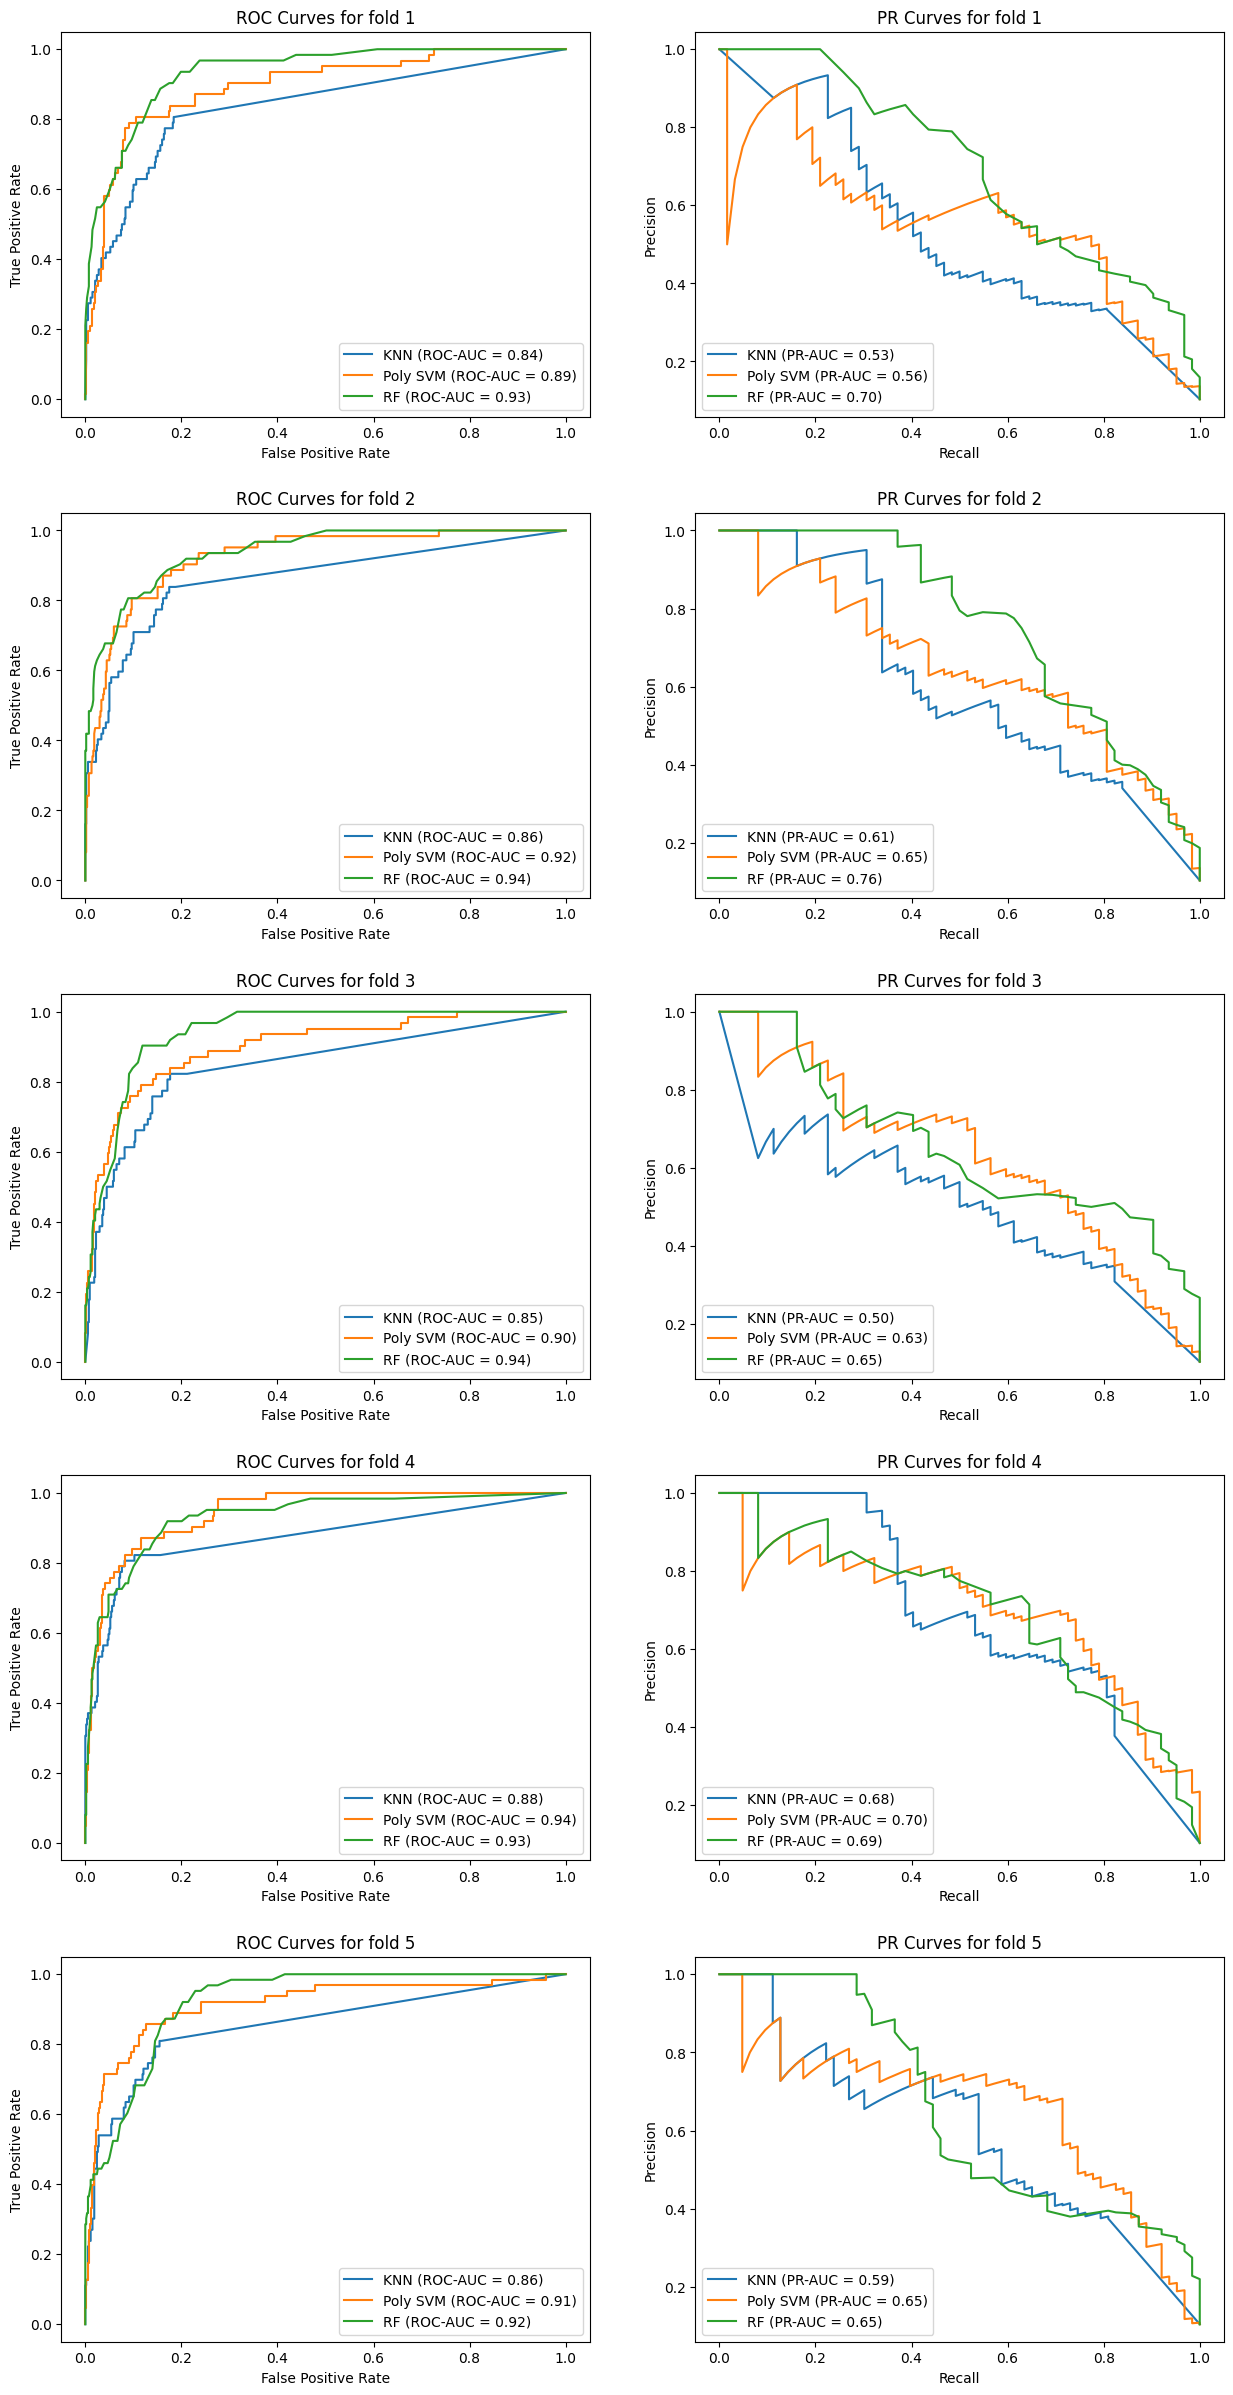

In [13]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.model_selection import train_test_split

# Create subplots
fig, axs = plt.subplots(5, 2, figsize=(15, 30))
fig.subplots_adjust(hspace=0.25)

# 5-fold stratified cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True)
fold_index = 0

# Loop through each fold
for train_index, test_index in skf.split(Xtrain, Ytrain):
    X_train_fold, X_test_fold = Xtrain[train_index], Xtrain[test_index]
    Y_train_fold, Y_test_fold = Ytrain[train_index], Ytrain[test_index]

    # Plot ROC and PR curves for each classifier
    for classifier_name, classifier in classifiers.items():
        classifier.fit(X_train_fold, Y_train_fold)

        # Get the probability scores for the positive class
        scores = classifier.predict_proba(X_test_fold)[:, 1]

        # Compute ROC curve
        fpr, tpr, _ = roc_curve(Y_test_fold, scores)
        roc_auc = auc(fpr, tpr)

        # Compute precision-recall curve
        precision, recall, _ = precision_recall_curve(Y_test_fold, scores)
        pr_auc = auc(recall, precision)

        # Plot ROC curve
        axs[fold_index, 0].plot(fpr, tpr, label=f'{classifier_name} (ROC-AUC = {roc_auc:.2f})')

        # Plot PR curve
        axs[fold_index, 1].plot(recall, precision, label=f'{classifier_name} (PR-AUC = {pr_auc:.2f})')

    # Set plot details for ROC curve
    axs[fold_index, 0].set_title('ROC Curves for fold ' + str(fold_index+1))
    axs[fold_index, 0].set_xlabel('False Positive Rate')
    axs[fold_index, 0].set_ylabel('True Positive Rate')
    axs[fold_index, 0].legend(loc='lower right')

    # Set plot details for PR curve
    axs[fold_index, 1].set_title('PR Curves for fold ' + str(fold_index+1))
    axs[fold_index, 1].set_xlabel('Recall')
    axs[fold_index, 1].set_ylabel('Precision')
    axs[fold_index, 1].legend(loc='lower left')

    fold_index += 1

# Show the plots
plt.show()

Consider the same criteria as in Question 3, we may prefer Polynomial SVM as the best classifier for unscaled data.

In [46]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

the_chosen_one = make_pipeline(StandardScaler(), SVC(probability=True, C=100, gamma=0.001, kernel='rbf'))

the_chosen_one.fit(Xtrain, Ytrain)

Ytest = the_chosen_one.predict(Xtest)

In [47]:
# Count positive examples
test_positive = np.sum(Ytest == 1)

# Count negative examples
test_negative = np.sum(Ytest == -1)

print("Number examples in the test data labeled as positive :", test_positive)
print("Number examples in the test data labeled as negative :", test_negative)

Number examples in the test data labeled as positive : 0
Number examples in the test data labeled as negative : 3000


Again we see that though RBF kernel SVM with standard scaling performs very well within the training dataset when using cross validation, it does not generalize when we try to use it on test data - none of the test example is labeled as positive!

In [35]:
the_chosen_one = SVC(probability=True, C=10, degree=2, kernel='poly')

the_chosen_one.fit(Xtrain, Ytrain)

Ytest = the_chosen_one.predict(Xtest)

In [36]:
# Count positive examples
test_positive = np.sum(Ytest == 1)

# Count negative examples
test_negative = np.sum(Ytest == -1)

print("Number examples in the test data labeled as positive :", test_positive)
print("Number examples in the test data labeled as negative :", test_negative)

Number examples in the test data labeled as positive : 305
Number examples in the test data labeled as negative : 2695


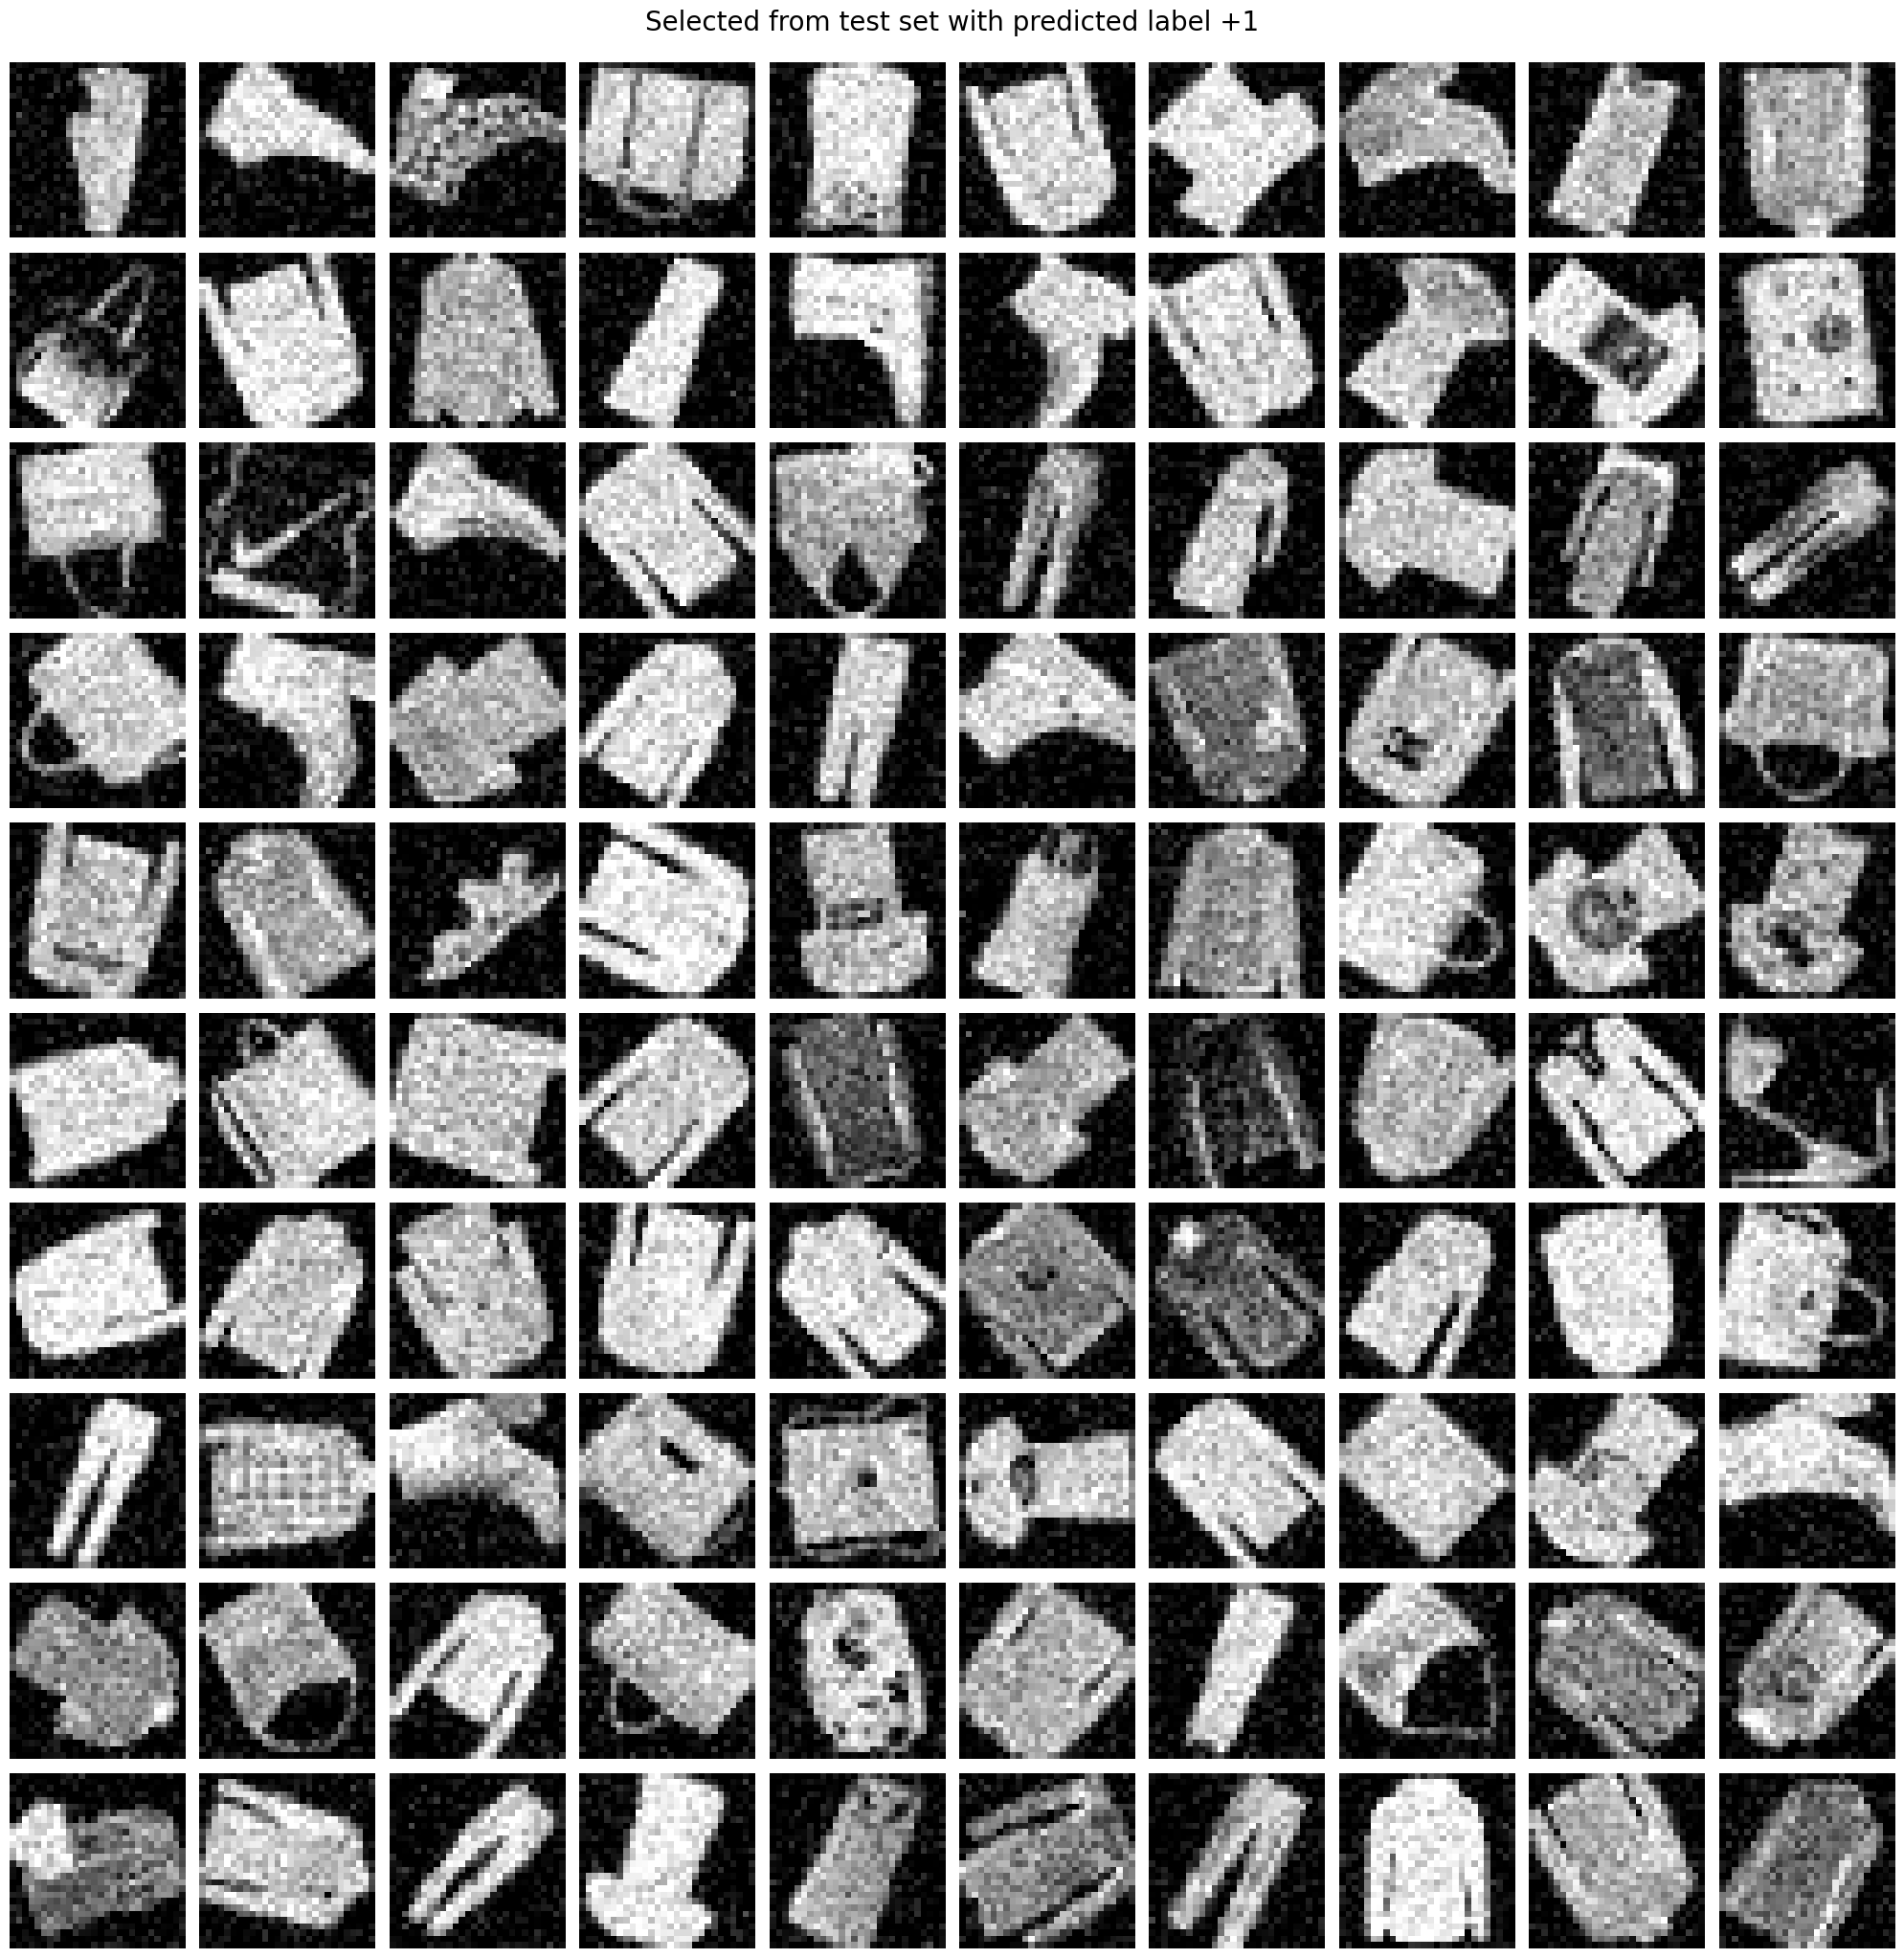

In [37]:
import matplotlib.pyplot as plt

# Create a figure for plotting
fig, axes = plt.subplots(10, 10, figsize=(20, 20))

# Select 100 random objects from test examples labeled as positive
class_indices = np.where(Ytest == 1)[0]
random_indices = np.random.choice(class_indices, size=100, replace=False)
random_objects = Xtest[random_indices]

# Reshape and display the flattened 28x28 arrays
for i in range(100):
    axes[i // 10, i % 10].matshow(random_objects[i].reshape(28, 28), cmap='gray')
    axes[i // 10, i % 10].axis('off')

# Add a title to the entire figure
plt.tight_layout()
plt.suptitle('Selected from test set with predicted label +1', fontsize=20, y=1.02)

plt.show()